In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
from matplotlib.image import imread
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import load_img,array_to_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential

from keras.layers import Dropout, BatchNormalization 
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten,GlobalAveragePooling2D, Reshape, Input, Average
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.applications import DenseNet121, DenseNet201
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2

In [2]:
# Define the Path of the dataset
path ='data'

In [3]:
# list all the subfolder in the directory (path)
os.listdir(path)

['rainbow',
 'rime',
 'cloudy',
 'sunrise',
 'lightning',
 'sandstorm',
 'foggy',
 'rainy']

In [4]:
# mean of all images dimensions
input_shape =  (542,375,3)

## Now let's see the dataset is Balanced or not

In [5]:
count_images ={}
for folder in os.listdir(path) :
    folder_path = os.path.join(path , folder)
    num_images = len(os.listdir(folder_path))
    count_images[folder] =  num_images
    print(f"{folder} folder has {num_images} images " )
    
    

rainbow folder has 450 images 
rime folder has 400 images 
cloudy folder has 350 images 
sunrise folder has 349 images 
lightning folder has 400 images 
sandstorm folder has 400 images 
foggy folder has 384 images 
rainy folder has 383 images 


## Now let's prepare the Data for training 

In [6]:
def prepare_data(path) :
    images = []
    labels = []
    classes_names = os.listdir(path)
    # assign each class a unique id 
    class_dic ={}
    for id , name in enumerate(classes_names) :
        class_dic[name] = id 
    for class_name in classes_names :
        class_path = os.path.join(path , class_name)
        for image in os.listdir(class_path) :
            image_path = os.path.join(class_path , image)
            image = load_img(image_path ,target_size=(542,375))
            image=  img_to_array(image)
            image /=255.0 # normalize the image pixels to range from 0 to 1
            images.append(image) # append the image 
            labels.append(class_dic[class_name]) # and append it is crosspending labels
    images = np.array(images)
    labels = np.array(labels)
    return images , labels



In [7]:
all_images , all_labels = prepare_data(path)
print(all_images.shape)
print(all_labels.shape)


(3116, 542, 375, 3)
(3116,)


In [8]:
len(all_labels)

3116

## Encoding the labels with onehot encoding

In [9]:
encoded_labels = tf.keras.utils.to_categorical(all_labels , num_classes =8)
encoded_labels


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Spit the data into Train , Val  and Test

In [10]:

X_train, X_test, y_train, y_test = train_test_split(all_images, encoded_labels, test_size=0.2, random_state=2025)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2025)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape: (1993, 542, 375, 3)
Validation data shape: (499, 542, 375, 3)
Test data shape: (624, 542, 375, 3)


## Now let's Build the Model

In [11]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import models ,layers ,regularizers
batch_size = 16 
img_width ,img_height =542,375
num_classes = 8
base_model = DenseNet121(include_top = False , weights ='imagenet' , input_shape=(img_width , img_height ,3))
model =models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01)))
epochs =30
lr=1e-4
opt=tf.keras.optimizers.Adam(lr)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'],)
model.build(input_shape=(batch_size, img_width, img_height, 3))
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (16, 17, 11, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (16, 1024)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 256)              │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (16, 256)              │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (16, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 8)                │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,302,984 (27.86 MB)

 Trainable params: 7,218,824 (27.54 MB)

 Non-trainable params: 84,160 (328.75 KB)

In [12]:
from keras.callbacks import  EarlyStopping
callbacks=[
    EarlyStopping(monitor = 'val_accuracy' , patience=3 ,verbose =True ,restore_best_weights=True)
    
]

In [13]:
hist = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    callbacks=callbacks, 
    verbose=True
)

Epoch 1/30


I0000 00:00:1734529819.072856     258 service.cc:145] XLA service 0x794668001fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734529819.072908     258 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734529819.072912     258 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734529958.439061     258 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion_1', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1734529958.668233     258 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.5024 - loss: 5.6369

I0000 00:00:1734530147.886328     258 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_1', 8 bytes spill stores, 8 bytes spill loads



100/100 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.5061 - loss: 5.6211 - val_accuracy: 0.7945 - val_loss: 4.2542
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 723ms/step - accuracy: 0.9176 - loss: 3.6803 - val_accuracy: 0.9048 - val_loss: 3.3594
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 724ms/step - accuracy: 0.9516 - loss: 3.0833 - val_accuracy: 0.9424 - val_loss: 2.8304
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 723ms/step - accuracy: 0.9646 - loss: 2.6917 - val_accuracy: 0.9398 - val_loss: 2.5842
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 717ms/step - accuracy: 0.9619 - loss: 2.4256 - val_accuracy: 0.9323 - val_loss: 2.4025
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 727ms/step - accuracy: 0.9784 - loss: 2.2111 - val_accuracy: 0.9574 - val_loss: 2.1987
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 719ms/step - accuracy: 0.9825 - loss: 2.0635 - val_accuracy: 0.9674 - val_loss: 2.0043
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 722ms/step - accuracy: 0.9872 - loss: 1.9459 - val_a

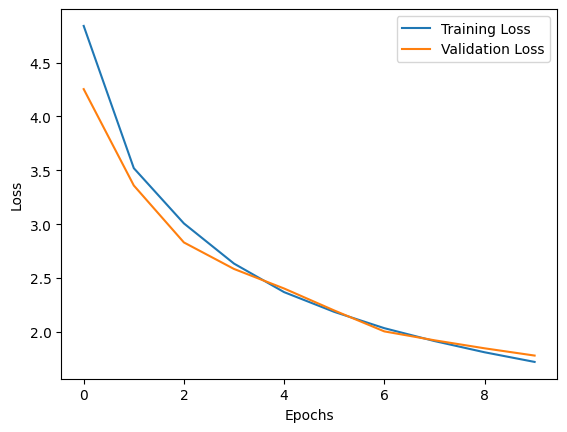

In [14]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

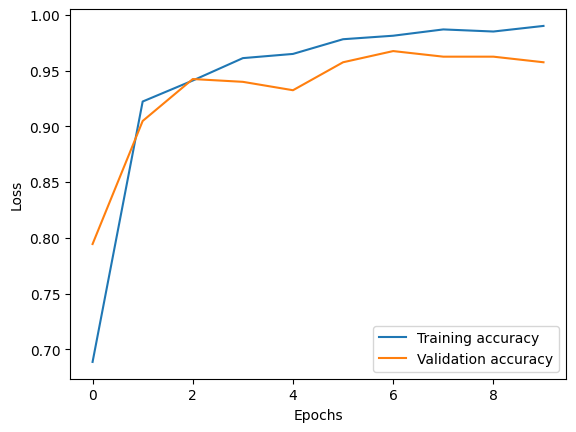

In [15]:
plt.plot(hist.history['accuracy'], label='Training accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

2024-12-18 14:08:12.492929: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,128,68,47]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,480,68,47]{3,2,1,0}, f32[128,480,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-18 14:08:12.659397: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.166605273s
Trying algorithm eng3{k11=2} for conv (f32[32,128,68,47]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,480,68,47]{3,2,1,0}, f32[128,480,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_res

20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 344ms/step - accuracy: 0.9648 - loss: 2.0295
Test Accuracy: 0.9631410241127014


In [17]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)  # True labels

20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step


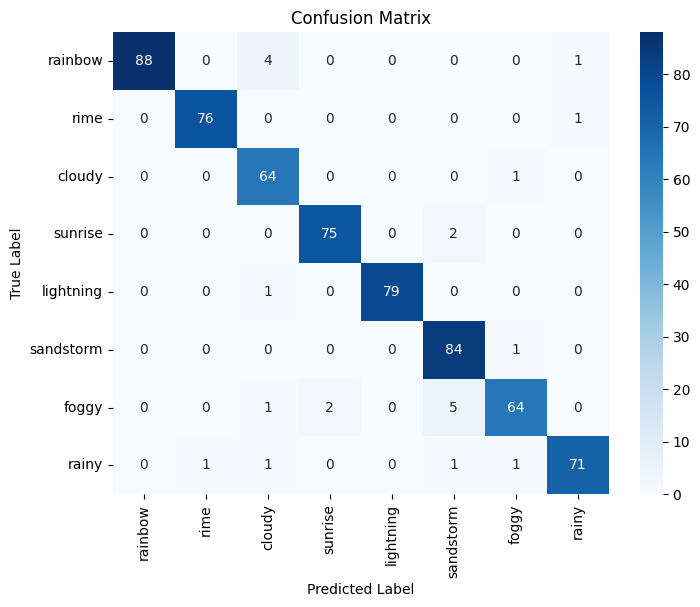

In [18]:
#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
classes_names = os.listdir(path)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## plot the Roc curve

39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step


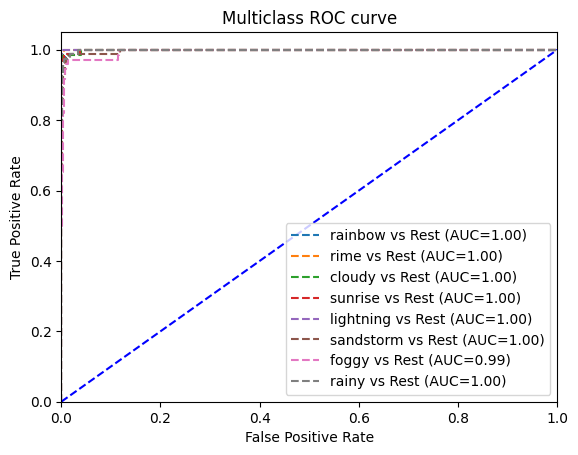

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
classes = os.listdir(path)
pred_prob = model.predict(X_test, batch_size=batch_size) 
y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))  
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = num_classes 
for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], linestyle='--', label='%s vs Rest (AUC=%0.2f)' % (classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'b--')


plt.xlim([0, 1])
plt.ylim([0, 1.05])

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='lower right')

# Show the plot
plt.show()


In [20]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        93
           1       0.99      0.99      0.99        77
           2       0.90      0.98      0.94        65
           3       0.97      0.97      0.97        77
           4       1.00      0.99      0.99        80
           5       0.91      0.99      0.95        85
           6       0.96      0.89      0.92        72
           7       0.97      0.95      0.96        75

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624

